In [1]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
from datetime import datetime

In [2]:
#### Import ####
# Elke CSV als aparte DataFrame inladen

data_path = "./data"
csv_files = {}

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            # Gebruik de bestandsnaam (zonder extensie) als sleutel in de dictionary
            csv_name = os.path.splitext(file)[0]
            csv_files[csv_name] = pd.read_csv(file_path)

for name, df in csv_files.items():
    print(f"DataFrame '{name}' ingeladen, aantal rijen: {len(df)}")

DataFrame 'coteq_electricity_2013' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2014' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2015' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2016' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2017' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2018' ingeladen, aantal rijen: 2503
DataFrame 'coteq_electricity_2019' ingeladen, aantal rijen: 2563
DataFrame 'coteq_electricity_2020' ingeladen, aantal rijen: 2575
DataFrame 'endinet_electricity_01012011' ingeladen, aantal rijen: 5743
DataFrame 'endinet_electricity_01012012' ingeladen, aantal rijen: 5795
DataFrame 'endinet_electricity_01012013' ingeladen, aantal rijen: 5883
DataFrame 'endinet_electricity_01012014' ingeladen, aantal rijen: 4546
DataFrame 'endinet_electricity_01012015' ingeladen, aantal rijen: 4550
DataFrame 'endinet_electricity_01012016' ingeladen, aantal rijen: 4565
DataFrame 'enduriselectricity_01012013' ingeladen, aan

In [3]:
#### EDA ####
# Consistentie check in DataFrame kolommen

for name, df in csv_files.items():
    print(f"DataFrame '{name}' heeft de volgende kolommen:")
    print(df.columns.tolist())  
    print("-" * 40)

DataFrame 'coteq_electricity_2013' heeft de volgende kolommen:
['net_manager', 'purchase_area', 'street', 'zipcode_from', 'zipcode_to', 'city', 'num_connections', 'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 'type_of_connection', 'annual_consume', 'annual_consume_lowtarif_perc', 'smartmeter_perc']
----------------------------------------
DataFrame 'coteq_electricity_2014' heeft de volgende kolommen:
['net_manager', 'purchase_area', 'street', 'zipcode_from', 'zipcode_to', 'city', 'num_connections', 'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 'type_of_connection', 'annual_consume', 'annual_consume_lowtarif_perc', 'smartmeter_perc']
----------------------------------------
DataFrame 'coteq_electricity_2015' heeft de volgende kolommen:
['net_manager', 'purchase_area', 'street', 'zipcode_from', 'zipcode_to', 'city', 'num_connections', 'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 'type_of_connection', 'annual_consume', 'annual_cons

In [4]:
#### Feature Engineering ####
# Nieuwe features vanuit DataFrame namen halen
# DataFramen samenvoegen

combined_data = []  

for name, df in csv_files.items():
    leverancier = name.split('_')[0]
    type_verbruik = name.split('_')[1]
    jaar = re.search(r'\d{4}$', name)
    jaar = int(jaar.group()) if jaar else None
    
    df['leverancier'] = leverancier
    df['type'] = type_verbruik
    df['jaar'] = int(jaar)
    
    combined_data.append(df)

final_df = pd.concat(combined_data, ignore_index=True)

In [5]:
final_df.head()

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,num_connections,delivery_perc,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,leverancier,type,jaar,ï»¿NETBEHEERDER,STANDAARDDEVIATIE,%Defintieve aansl (NRM)
0,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,Dorpsstraat,7468CP,7471AA,ENTER,19.0,89.47,94.74,89,1x35,4122.0,89.47,0.0,coteq,electricity,2013,NaN,NaN,NaN
1,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AB,7471AB,GOOR,37.0,100.00,100.00,86,1x35,1800.0,94.59,0.0,coteq,electricity,2013,NaN,NaN,NaN
2,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AC,7471AC,GOOR,16.0,100.00,100.00,100,1x35,1315.0,100.00,0.0,coteq,electricity,2013,NaN,NaN,NaN
3,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AD,7471AE,GOOR,25.0,92.00,84.00,44,1x35,6379.0,92.00,0.0,coteq,electricity,2013,NaN,NaN,NaN
4,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,Kerkstraat,7471AG,7471AG,GOOR,14.0,85.71,100.00,36,1x35,4404.0,92.86,0.0,coteq,electricity,2013,NaN,NaN,NaN


In [6]:
#### Data Cleaning ####
# Missing Values berekenen en percentages weergeven

missing_counts = final_df.isnull().sum()  
total_rows = len(final_df)  

missing_percentages = (missing_counts / total_rows) * 100

print("Ontbrekende waarden per kolom (aantal en percentage):\n")
for col, count, percent in zip(final_df.columns, missing_counts, missing_percentages):
    print(f"{col}: {count} ontbrekend ({percent:.2f}%)")

Ontbrekende waarden per kolom (aantal en percentage):

net_manager: 29224 ontbrekend (0.72%)
purchase_area: 886657 ontbrekend (21.75%)
street: 0 ontbrekend (0.00%)
zipcode_from: 0 ontbrekend (0.00%)
zipcode_to: 0 ontbrekend (0.00%)
city: 0 ontbrekend (0.00%)
num_connections: 7 ontbrekend (0.00%)
delivery_perc: 2069 ontbrekend (0.05%)
perc_of_active_connections: 1487 ontbrekend (0.04%)
type_conn_perc: 124940 ontbrekend (3.06%)
type_of_connection: 107588 ontbrekend (2.64%)
annual_consume: 0 ontbrekend (0.00%)
annual_consume_lowtarif_perc: 13268 ontbrekend (0.33%)
smartmeter_perc: 13268 ontbrekend (0.33%)
leverancier: 0 ontbrekend (0.00%)
type: 0 ontbrekend (0.00%)
jaar: 0 ontbrekend (0.00%)
ï»¿NETBEHEERDER: 4048128 ontbrekend (99.28%)
STANDAARDDEVIATIE: 3991014 ontbrekend (97.88%)
%Defintieve aansl (NRM): 4053010 ontbrekend (99.40%)


In [7]:
print(final_df.columns.tolist())

['net_manager', 'purchase_area', 'street', 'zipcode_from', 'zipcode_to', 'city', 'num_connections', 'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 'type_of_connection', 'annual_consume', 'annual_consume_lowtarif_perc', 'smartmeter_perc', 'leverancier', 'type', 'jaar', 'ï»¿NETBEHEERDER', 'STANDAARDDEVIATIE', '%Defintieve aansl (NRM)']


In [8]:
final_df = final_df.drop(columns=['ï»¿NETBEHEERDER', 'STANDAARDDEVIATIE', '%Defintieve aansl (NRM)'])
final_df.dropna(subset=['annual_consume'], inplace=True)
final_df.drop_duplicates(inplace=True)

In [9]:
final_df.head()

,net_manager,purchase_area,street,zipcode_from,zipcode_to,city,num_connections,delivery_perc,perc_of_active_connections,type_conn_perc,type_of_connection,annual_consume,annual_consume_lowtarif_perc,smartmeter_perc,leverancier,type,jaar
0,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,Dorpsstraat,7468CP,7471AA,ENTER,19.0,89.47,94.74,89,1x35,4122.0,89.47,0.0,coteq,electricity,2013
1,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AB,7471AB,GOOR,37.0,100.00,100.00,86,1x35,1800.0,94.59,0.0,coteq,electricity,2013
2,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AC,7471AC,GOOR,16.0,100.00,100.00,100,1x35,1315.0,100.00,0.0,coteq,electricity,2013
3,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,De Stoevelaar,7471AD,7471AE,GOOR,25.0,92.00,84.00,44,1x35,6379.0,92.00,0.0,coteq,electricity,2013
4,Coteq Netbeheer BV,Netbeheerder Centraal Overijssel B.V.,Kerkstraat,7471AG,7471AG,GOOR,14.0,85.71,100.00,36,1x35,4404.0,92.86,0.0,coteq,electricity,2013


In [10]:
#### Feature Engineering ####
# Aggregeren op postcode, leverancier en jaar

aggregated_df = final_df.groupby(['zipcode_from', 'zipcode_to', 'leverancier', 'jaar']).agg({
    'annual_consume': 'sum',      
    'num_connections': 'sum'     
}).reset_index()

aggregated_df['gemiddeld_verbruik'] = aggregated_df['annual_consume'] / aggregated_df['num_connections']

print(aggregated_df.head())

  zipcode_from zipcode_to leverancier  jaar  annual_consume  num_connections  \
0       1000AA     1011AA     liander  2009         12958.0             15.0   
1       1000AA     1011AA     liander  2010         11420.0             15.0   
2       1000AA     1011AA     liander  2011          8565.0             16.0   
3       1000AA     1011AA     liander  2012          8545.0             17.0   
4       1000AA     1011AA     liander  2013          9064.0             17.0   

   gemiddeld_verbruik  
0          863.866667  
1          761.333333  
2          535.312500  
3          502.647059  
4          533.176471  


In [11]:
#### Outlier Removal ####

Q1 = aggregated_df['gemiddeld_verbruik'].quantile(0.25)
Q3 = aggregated_df['gemiddeld_verbruik'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

aggregated_df = aggregated_df[(aggregated_df['gemiddeld_verbruik'] >= lower_bound) & 
                            (aggregated_df['gemiddeld_verbruik'] <= upper_bound)]

print(aggregated_df.head())


   zipcode_from zipcode_to leverancier  jaar  annual_consume  num_connections  \
7        1011AA     1011AB     liander  2016         13791.0             33.0   
8        1011AA     1011AB     liander  2017         13601.0             34.0   
9        1011AA     1011AB     liander  2018         14403.0             35.0   
10       1011AA     1011AB     liander  2019         16589.0             36.0   
11       1011AA     1011AB     liander  2020         14940.0             43.0   

    gemiddeld_verbruik  
7           417.909091  
8           400.029412  
9           411.514286  
10          460.805556  
11          347.441860  


In [12]:
# # Extra Data Check
# valid_zipcodes = aggregated_df[(aggregated_df['zipcode_from'].str.match(r'^\d{4}[A-Z]{2}$')) & 
#                           (aggregated_df['zipcode_to'].str.match(r'^\d{4}[A-Z]{2}$'))]
# print(f"Data na normalisatie: {valid_zipcodes.head()}")

In [13]:
#### Feature Engineering ####
# Postcode koppelen met GeoJSON Postcodes

aggregated_df['postcode_4digit'] = aggregated_df['zipcode_from'].str[:4].astype(int)
aggregated_df = aggregated_df[aggregated_df['postcode_4digit'] > 0000]

In [14]:
aggregated_df.head()

,zipcode_from,zipcode_to,leverancier,jaar,annual_consume,num_connections,gemiddeld_verbruik,postcode_4digit
7,1011AA,1011AB,liander,2016,13791.0,33.0,417.909091,1011
8,1011AA,1011AB,liander,2017,13601.0,34.0,400.029412,1011
9,1011AA,1011AB,liander,2018,14403.0,35.0,411.514286,1011
10,1011AA,1011AB,liander,2019,16589.0,36.0,460.805556,1011
11,1011AA,1011AB,liander,2020,14940.0,43.0,347.441860,1011


In [15]:
# GeoJSON Inladen

geojson_path = "./georef-netherlands-postcode-pc4.geojson"
geojson = gpd.read_file(geojson_path)
geojson['pc4_code'] = geojson['pc4_code'].astype(int)

print(geojson.columns) 
print(geojson.head()) 

Index(['geo_point_2d', 'pc4_code', 'year', 'gem_code', 'prov_code',
       'prov_name', 'gem_name', 'geometry'],
      dtype='object')
                                        geo_point_2d  pc4_code  year gem_code  \
0  { "lon": 4.46740072448, "lat": 51.788861227600...      3273  2020     1963   
1  { "lon": 4.6696329543199999, "lat": 51.8146764...      3311  2020      505   
2  { "lon": 4.7011524639099997, "lat": 51.7950291...      3319  2020      505   
3  { "lon": 4.9642664539899997, "lat": 52.0957634...      3481  2020      632   
4  { "lon": 5.1324759122500003, "lat": 52.1084854...      3571  2020      344   

  prov_code     prov_name        gem_name  \
0        28  Zuid-Holland  Hoeksche Waard   
1        28  Zuid-Holland       Dordrecht   
2        28  Zuid-Holland       Dordrecht   
3        26       Utrecht         Woerden   
4        26       Utrecht         Utrecht   

                                            geometry  
0  POLYGON ((4.43784 51.79863, 4.43785 51.79863, ...

In [16]:
# Controleer ontbrekende postcodes

missing_postcodes = set(aggregated_df['postcode_4digit']) - set(geojson['pc4_code'])
print("Ontbrekende postcodes:", missing_postcodes)

Ontbrekende postcodes: {3200, 6400, 3330, 4100, 2950, 3340, 3727, 6800, 1300, 3220, 6040, 2588, 3100, 4130, 7330, 1192, 2600, 3370, 3624, 5800, 6829, 2990, 1200, 7089, 5940, 6710, 3000, 3130, 3900, 2621, 9662, 3517, 7100, 2500, 2630, 7750, 1225, 1099, 3661, 2640, 5456, 8402, 1234, 1876, 2130, 2900, 6864, 7000, 3677, 2270, 2910, 2528, 3167, 3937, 3300, 7270, 2535, 2280, 2920, 4199, 4200, 3180, 2030, 3952, 2930, 5746, 6771, 7154, 3190, 3321, 2682, 2429, 2942}


In [17]:
# Controleer of de ontbrekende postcodes geldig zijn

valid_postcodes = aggregated_df['postcode_4digit'].unique()
invalid_postcodes = set(valid_postcodes) - set(geojson['pc4_code'])
print("Ongeldige postcodes:", invalid_postcodes)

Ongeldige postcodes: {3200, 6400, 3330, 4100, 2950, 3340, 3727, 6800, 1300, 3220, 6040, 2588, 3100, 4130, 7330, 1192, 2600, 3370, 3624, 5800, 6829, 2990, 1200, 7089, 5940, 6710, 3000, 3130, 3900, 2621, 9662, 3517, 7100, 2500, 2630, 7750, 1225, 1099, 3661, 2640, 5456, 8402, 1234, 1876, 2130, 2900, 6864, 7000, 3677, 2270, 2910, 2528, 3167, 3937, 3300, 7270, 2535, 2280, 2920, 4199, 4200, 3180, 2030, 3952, 2930, 5746, 6771, 7154, 3190, 3321, 2682, 2429, 2942}


In [18]:
# Verwijder rijen met ongeldige postcodes

aggregated_df = aggregated_df[~aggregated_df['postcode_4digit'].isin(missing_postcodes)]

In [19]:
# Vormen plotbare DataFrame

geo_mapping = geojson.set_index('pc4_code')['geo_point_2d'].to_dict()
merged = aggregated_df.merge(geojson, left_on='postcode_4digit', right_on='pc4_code', how='left')
print(merged[['postcode_4digit', 'geometry', 'jaar', 'gemiddeld_verbruik']].head(20))

    postcode_4digit                                           geometry  jaar  \
0              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2016   
1              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2017   
2              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2018   
3              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2019   
4              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2020   
5              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2009   
6              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2010   
7              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2011   
8              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2012   
9              1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2013   
10             1011  POLYGON ((4.90562 52.37935, 4.90562 52.37935, ...  2014   
11             1011  POLYGON ((4.90562 5

In [20]:
#### Export ####
# Subsets maken

subsets_per_year = {year: df for year, df in merged.groupby('jaar')}
for year, subset in subsets_per_year.items():
    print(f"Subset voor jaar {year}: {len(subset)} rijen")

Subset voor jaar 2009: 197713 rijen
Subset voor jaar 2010: 296669 rijen
Subset voor jaar 2011: 307204 rijen
Subset voor jaar 2012: 309509 rijen
Subset voor jaar 2013: 325872 rijen
Subset voor jaar 2014: 326111 rijen
Subset voor jaar 2015: 329128 rijen
Subset voor jaar 2016: 331448 rijen
Subset voor jaar 2017: 334116 rijen
Subset voor jaar 2018: 339447 rijen
Subset voor jaar 2019: 340049 rijen
Subset voor jaar 2020: 334177 rijen


In [21]:
## Subsets opslaan

# for year, subset in subsets_per_year.items():
#     subset.to_csv(f"processed_data_{year}.csv", index=False)

In [22]:
#### Visualisatie ####
# Kies te verwerken jaar

jaar = 2009

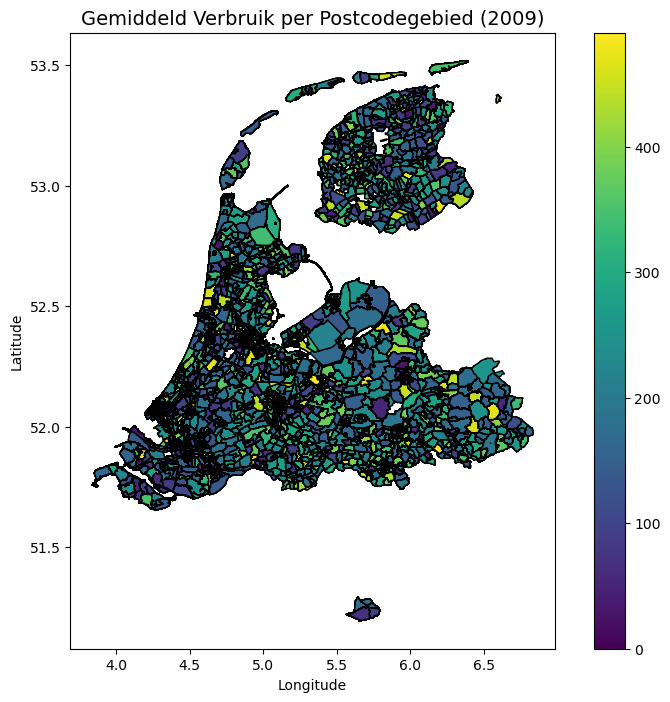

In [23]:
data_for_year = merged[merged['jaar'] == jaar ]
gdf = gpd.GeoDataFrame(data_for_year, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    column='gemiddeld_verbruik',  
    cmap='viridis',              
    legend=True,                 
    ax=ax,                       
    edgecolor='black'            
)

plt.title(f"Gemiddeld Verbruik per Postcodegebied ({jaar})", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()
